In [ ]:
# Date    :   2024-12-10
# Author  :   Dongwoo Yoon
# Contact :   dbsehddn0901@gmail.com


# 웹 크롤링 (Web Crawling)
해당 파일은 윈도우 로컬 환경에서 실행하였습니다.

In [ ]:
# Selenium: 브라우저 자동화를 통해 동적 웹 페이지의 데이터 크롤링을 가능하게 함
!pip install selenium

In [ ]:
# BeautifulSoup4: HTML 및 XML 문서를 쉽게 파싱하고 데이터 추출을 가능하게 함
!pip install beautifulsoup4

In [ ]:
# Dask: 대규모 데이터 처리를 병렬로 실행하여 속도를 향상하고 효율성을 높임
!pip install dask

In [5]:
import os
import time
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import dask
from dask import delayed, compute

In [6]:
honeybee_spices = ["Apis cerana", "Apis mellifera"]
hornet_spices = ["Vespa velutina", "Vespa mandarinia"]

In [7]:
def setup_driver():
    """Setup a Selenium WebDriver with headless options."""
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    return webdriver.Chrome(options=options)

In [8]:
def download_images(query, num_images):
    """Crawl images for a single query."""
    driver = setup_driver()
    save_dir = f"./dataset/{query}"
    os.makedirs(save_dir, exist_ok=True)

    # 구글 이미지 검색
    driver.get(f"https://www.google.com/search?q={query}&tbm=isch")
    print(f"Searching images for: {query}")

    count = 0
    while count < num_images:
        # BeautifulSoup으로 HTML 파싱
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        # CSS Selector로 현재 로드된 이미지 가져오기
        images = soup.select("#rso > div > div > div.wH6SXe.u32vCb > div > div img")

        for img in images:
            if count >= num_images:
                break
            img_url = img.get('src')
            if img_url and img_url.startswith('http'):
                try:
                    img_data = requests.get(img_url).content
                    file_name = os.path.join(save_dir, f"{query}_{count}.jpg")
                    with open(file_name, 'wb') as f:
                        f.write(img_data)
                    print(f"Saved: {file_name}")
                    count += 1
                except Exception as e:
                    print(f"Failed to download {img_url}: {e}")

        # 스크롤을 통해 추가 이미지 로드
        print("Scrolling to load more images...")
        driver.find_element(By.TAG_NAME, "body").send_keys(Keys.END)
        time.sleep(1)

    driver.quit()  # 브라우저 종료
    print(f"Finished downloading {count} images for query: {query}")


In [9]:
def parallel_image_crawl(num_images, object_list):
    """Use Dask to parallelize image crawling for multiple queries."""
    tasks = [delayed(download_images)(obj, num_images) for obj in object_list]
    compute(*tasks)

In [ ]:
parallel_image_crawl(1500, honeybee_spices)

In [ ]:
parallel_image_crawl(3000, hornet_spices)

In [ ]:
!pip install matplotlib

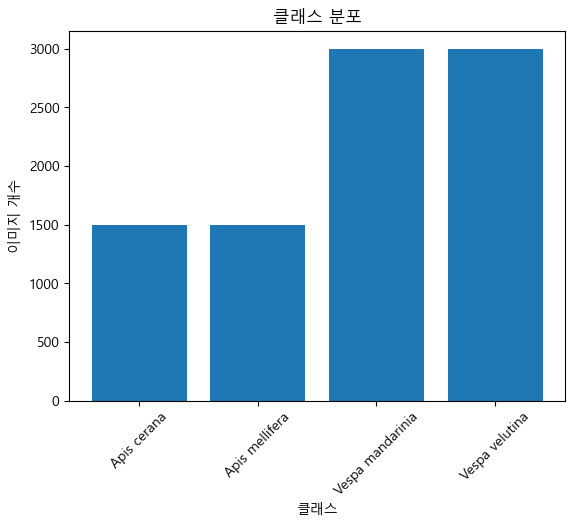

In [12]:
import os
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font', family='Malgun Gothic')  # Windows 환경
# rc('font', family='Nanum Gothic')  # Linux 환경 (예: Ubuntu)

def visualize_class_distribution(base_dir):
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))

    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel("클래스")
    plt.ylabel("이미지 개수")
    plt.title("클래스 분포")
    plt.xticks(rotation=45)
    plt.show()

visualize_class_distribution("./dataset")


In [ ]:
from PIL import Image

def remove_invalid_images(base_dir):
    invalid_images = []
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
                    if img.size[0] < 100 or img.size[1] < 100:
                        invalid_images.append(img_path)
            except Exception as e:
                invalid_images.append(img_path)

    for img_path in invalid_images:
        print(f"Removing invalid image: {img_path}")
        os.remove(img_path)

remove_invalid_images("./dataset")

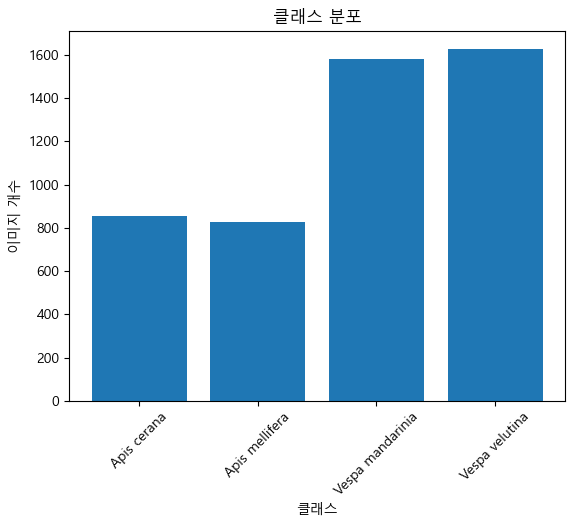

In [14]:
visualize_class_distribution("./dataset")

In [ ]:
import hashlib

def remove_duplicates(base_dir):
    hashes = set()
    duplicates = []

    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            with open(img_path, 'rb') as img_file:
                img_hash = hashlib.md5(img_file.read()).hexdigest()
                if img_hash in hashes:
                    duplicates.append(img_path)
                else:
                    hashes.add(img_hash)

    for img_path in duplicates:
        print(f"Removing duplicate image: {img_path}")
        os.remove(img_path)

remove_duplicates("./dataset")

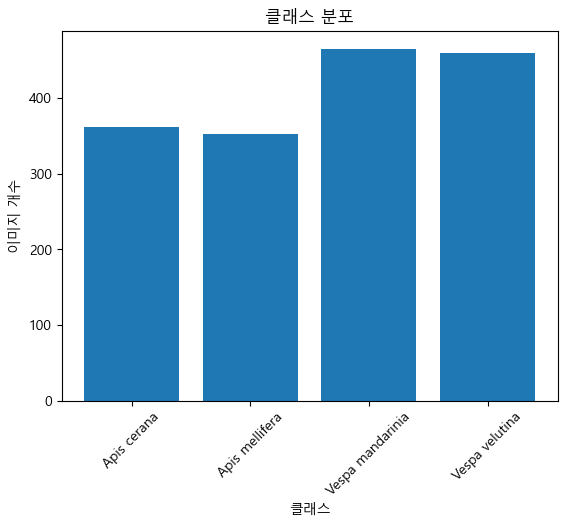

In [16]:
visualize_class_distribution("./dataset")